# Burger's Equation in 1D

Here we explore numerical solutions to Burger's equation equation in 1D

\begin{align}
  \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}
  = \nu\frac{\partial^2 u}{\partial x^2}
\end{align}

where $u = u(x,t)$, and $\nu$ is taken here to be a constant. Note that this equation has an advective term as in the non-linear advection equation, and it also has a diffusive term as in the diffusion equation.  

Treating each term as we have done previously gives

\begin{align}
  \frac{u^{n+1}_{i} - u^{n}_{i}}{\Delta{t}}
  + u^{n}_{i}\frac{u^{n}_{i} - u^{n}_{i-1}}{\Delta{x}}
  = \nu\frac{u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1}}{(\Delta{x})^2}
\end{align}

which after re-arranging becomes

\begin{align}
  u^{n+1}_{i} = u^{n}_{i}
  - u^{n}_{i}\frac{\Delta{t}}{\Delta{x}}\left(u^{n}_{i} - u^{n}_{i-1}\right)
  + \frac{\nu\Delta{t}}{(\Delta{x})^2}\left(u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1}\right)
\end{align}

### Initial conditions

\begin{align}
  u(x,0) = -\frac{2\nu}{\phi_{0}}\frac{\partial\phi_{0}}{\partial x} + 4
\end{align}

where 

\begin{align}
  \phi_{0}(x) = \phi(x,0) = \exp\left(\frac{-x^2}{4\nu}\right) 
  + \exp\left(\frac{-(x-2\pi)^2}{4\nu}\right)
\end{align}

### Boundary conditions

We will look for solutions that satisfy periodic boundary conditions

\begin{align}
  u(0,t) = u(2\pi,t)
\end{align}

### Exact solution

The exact analytical solution to this problem is 

\begin{align}
  u(x,t) = -\frac{2\nu}{\phi}\frac{\partial\phi}{\partial x} + 4
\end{align}

where 

\begin{align}
  \phi(x,t) = \exp\left(\frac{-(x-4t)^2}{4\nu(t+1)}\right) 
  + \exp\left(\frac{-(x-4t-2\pi)^2}{4\nu(t+1)}\right)
\end{align}

In [1]:
import numpy as np
import sympy as sym
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
from sympy import init_printing
#init_printing(use_latex=True)
init_printing()

In [3]:
# create symbolic expression for phi(x,t)
x, nu, t = sym.symbols('x nu t')
phi = (sym.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sym.exp(-(x - 4 * t - 2 * np.pi)**2 / (4 * nu * (t + 1))))

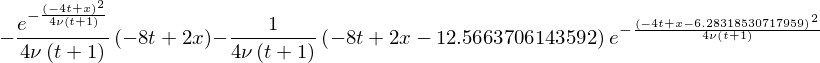

In [4]:
# take a partial derivative of phi(x,t) with respect to x
phiprime = phi.diff(x)
phiprime

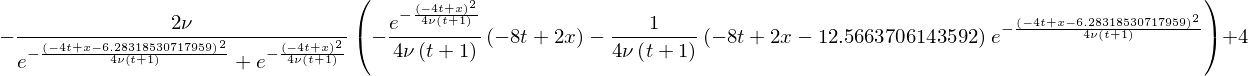

In [5]:
# create symbolic expression for u(x,t)
u = -2 * nu * (phiprime / phi) + 4
u

In [6]:
# lambdify u, in order to allow numeric evaluations
from sympy.utilities.lambdify import lambdify
ufunc = lambdify((t, x, nu), u)
ufunc(1, 4, 3) # sample numeric evaluation

In [7]:
# sample grid function for u
tmin = 0; tmax = 10; tstep = 1; ntsteps = tmax/tstep;
xmin = 0; xmax = 10; xstep = 1; nxsteps = xmax/xstep;
t = np.linspace(tmin, tmax, ntsteps)
x = np.linspace(xmin, xmax, nxsteps)
np.asarray([[ufunc(tn, xj, 3) for tn in t] for xj in x])

array([[ 3.77430539,  1.82721278,  1.20306204,  0.89651549,  0.71441407,
         0.59378379,  0.50799924,  0.44386941,  0.39411459,  0.35438894],
       [ 4.44154158,  2.30580342,  1.53169094,  1.14493932,  0.91376838,
         0.76015768,  0.65071876,  0.56880687,  0.50520184,  0.4543858 ],
       [ 4.48601825,  2.7529175 ,  1.85374867,  1.39103747,  1.11205066,
         0.92595301,  0.79309161,  0.69352055,  0.6161364 ,  0.55427388],
       [ 3.87739531,  3.15172756,  2.16684305,  1.634184  ,  1.30903318,
         1.09106841,  0.93506614,  0.81798149,  0.72690079,  0.65404204],
       [ 3.4401093 ,  3.48248354,  2.4679705 ,  1.87361845,  1.50444759,
         1.25538726,  1.07658401,  0.94215741,  0.83747575,  0.75367807],
       [ 3.73685821,  3.73008738,  2.7535973 ,  2.10843931,  1.69798165,
         1.4187763 ,  1.21757957,  1.06601243,  0.9478401 ,  0.85316871],
       [ 4.5363461 ,  3.8980733 ,  3.01998285,  2.33761313,  1.88927772,
         1.58108473,  1.35797944,  1.1895069 

In [7]:
# function to evolve Burger's equation    
def burger(nx):
    """
    evolve solutions to Burger's equation using finite differences
    
    INPUT
    nx = total number of spatial grid points
    
    OUTPUT
    animated plot of numerical and analytical solution
    """
    # diffusivity
    nu = 0.07
    #print('diffusion coefficient is',nu)

    # setup spatial grid (vertex-centered)
    L = 2*np.pi     # size of physical grid
    dx = L/(nx-1)   # grid spacing
    x = np.linspace(0, L, nx)
    #print('grid spacing is',dx)

    # setup time grid
    dt = dx*nu   # size of timesteps
    nt = 100     # total number of timesteps
    t = np.linspace(0, (nt-1)*dt, nt+1)
    #print('time stepsize is',dt)

    # initialize grid functions
    u = np.zeros(nx)  # grid function at the current step
    un = np.zeros(nx) # grid function at the previous step
    u_exact = np.zeros((nt,nx)) 
    
    # initial data
    u = np.asarray(ufunc(t[0], x, nu))
    umax0 = np.amax(u)

    # exact solution
    u_exact = np.asarray([[ufunc(tn, xj, nu) for xj in x] for tn in t])

    # function to update plot at each time step
    def uplot(timeStep, X, U, axis):
        axis.cla()                   #clear previous plot
        axis.set_xlim(0, L)          #set x limits of plot
        axis.set_ylim(0, 1.15*umax0) #set y limits of plot
        axis.set_xlabel('x')         #set x-axis label
        axis.set_ylabel('u(x,t)')    #set y-axis label
        axis.plot(X, U, 'g-', marker='o', label='numerical')  #plot u vs x
        axis.plot(X, u_exact[timeStep], 'b-', label='exact')  #plot u_exact vs x
        axis.set_title('time step = %.2f' % timeStep) #set title to current timestep
        axis.legend(loc='upper right') #set legend
        fig.canvas.draw()            #redraw figure
    
    # create figure
    fig = plt.figure(figsize=(7, 5), dpi=100)
    ax1 = fig.add_subplot(111)

    # solve
    for n in range(nt):
        # copy solution from previous time step
        un = u.copy()
        # update solution at interior points
        u[1:-1] = un[1:-1] \
        - dt/dx*un[1:-1]*(un[1:-1] - un[:-2]) \
        + nu*dt/dx**2*(un[2:] - 2*un[1:-1] + un[:-2])
        # update solution at boundary points
        u[0] = un[-2] #u at x=0
        u[-1] = u[1]  #u at x=L
        
        #plot configuration
        uplot(n, x, u, ax1)

<IPython.core.display.Javascript object>


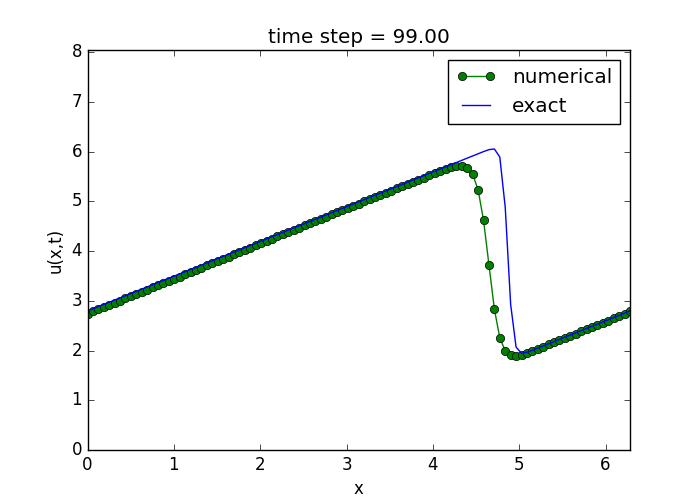

In [8]:
burger(101)